# Coding Assignment - "FL Design Principle"

## 1. Preparation

### 1.1 Libraries

In [41]:
import numpy as np 
import pandas as pd 
from datetime import datetime
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error

# We will use networx objects to store empirical graphs, local datasets and models
import networkx as nx 
from sklearn.neighbors import kneighbors_graph
from numpy import linalg as LA

### 1.2 Helper functions

In [42]:
# The function generates a scatter plot of nodes (=FMI stations) using 
# latitude and longitude as coordinates. 
def plotFMI(G_FMI): 
    num_stations = len(G_FMI.nodes)
    coords = [G_FMI.nodes[i]['coord'] for i in range(num_stations)]
    df_coords = pd.DataFrame(coords,columns=['latitude','longitude'])
    coords = np.hstack((df_coords["latitude"].to_numpy().reshape(-1,1),df_coords["longitude"].to_numpy().reshape(-1,1)))
    # Create a plot.
    fig, ax = plt.subplots()
    # Draw nodes and add labels.
    for node in G_FMI.nodes:
        ax.scatter(coords[node,1], coords[node,0], color='black', s=4, zorder=5)  # zorder ensures nodes are on top of edges
        ax.text(coords[node,1]+0.1, coords[node,0]+0.2, str(node), fontsize=8, ha='center', va='center', color='black', fontweight='bold')
    # Draw edges.
    for edge in G_FMI.edges:
        ax.plot([coords[edge[0],1],coords[edge[1],1]], [coords[edge[0],0],coords[edge[1],0]], linestyle='-', color='gray')

    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    ax.set_title('FMI stations')
    plt.show()
    
    
# The function connects each FMI station with 
# the nearest neighbours. 
def add_edges(graph, numneighbors=4):
    coords = [graph.nodes[i]['coord'] for i in range(num_stations)]
    df_coords = pd.DataFrame(coords,columns=['latitude','longitude'])
    coords = np.hstack((df_coords["latitude"].to_numpy().reshape(-1,1),df_coords["longitude"].to_numpy().reshape(-1,1)))
    A = kneighbors_graph(coords, numneighbors, mode='connectivity', include_self=False)
    nrnodes = len(graph.nodes)
    for iter_i in range(nrnodes): 
        for iter_ii in range(nrnodes): 
            if iter_i != iter_ii : 
                if A[iter_i,iter_ii]> 0 :
                    graph.add_edge(iter_i, iter_ii)
    return graph


# The function computes the average of the local loss 
# incurred by given local odel parameters.
def compute_train_err(graph, localparam):
   
    nrnodes = len(graph.nodes)
    tmp = 0 
    
    for iter_i in range(nrnodes): 
        predictions = np.ones((graph.nodes[iter_i]['samplesize'],1))*localparam[iter_i]
        local_loss = mean_squared_error(graph.nodes[iter_i]['y'], predictions) 
        tmp += local_loss
    
    train_err = tmp / nrnodes
            
    return train_err


# The function computes the total variation 
# of local model parameters.
def compute_totalvariation(graph,localparam):
   
    nrnodes = len(graph.nodes)
    tmp = 0 
    
    total_var = 0
    for u, v in graph.edges():
        total_var += (localparam[u] - localparam[v])**2
       
    return total_var


# The function below extracts a feature and label from each row 
# of dataframe df. Each row is expected to hold a FMI weather 
# measurement with cols "Latitude", "Longitude", "temp", "Timestamp" 
# returns numpy arrays X, y.
def ExtractFeaureMatrixLabvelVector(data):
    nrfeatures = 7 
    nrdatapoints = len(data)
    X = np.zeros((nrdatapoints, nrfeatures))
    y = np.zeros((nrdatapoints, 1))

    # Iterate over all rows in dataframe and create corresponding feature vector and label.
    for ind in range(nrdatapoints):
        # Latitude of FMI station, normalized by 100.
        lat = float(data['Latitude'].iloc[ind])/100
        # Longitude of FMI station, normalized by 100.
        lon = float(data['Longitude'].iloc[ind])/100
        # Temperature value of the data point.
        tmp = data['temp'].iloc[ind]
        # Read the date and time of the temperature measurement. 
        date_object = datetime.strptime(data['Timestamp'].iloc[ind], '%Y-%m-%d %H:%M:%S')
        # Extract year, month, day, hour, and minute. Normalize these values 
        # to ensure that the features are in range [0,1].
        year = float(date_object.year)/2025
        month = float(date_object.month)/13
        day = float(date_object.day)/32
        hour = float(date_object.hour)/25
        minute = float(date_object.minute)/61
        X[ind,:] = [lat, lon, year, month, day, hour, minute]
        y[ind,:] = tmp

    return X, y

## 2 Data

### 2.1 Dataset

In [43]:
# Import the weather measurements.
data = pd.read_csv('Assignment_MLBasicsData.csv')

# We consider each temperature measurement (=a row in dataframe) as a 
# separate data point.
# Get the numbers of data points and the unique stations.
num_stations = len(data.name.unique())
num_datapoints = len(data)

print('Number of stations: ', num_stations)
print('Number of data points: ', num_datapoints)
print(data.columns)

Number of stations:  207
Number of data points:  19768
Index(['Latitude', 'Longitude', 'Timestamp', 'temp', 'name'], dtype='object')


### 2.2 Empirical graph

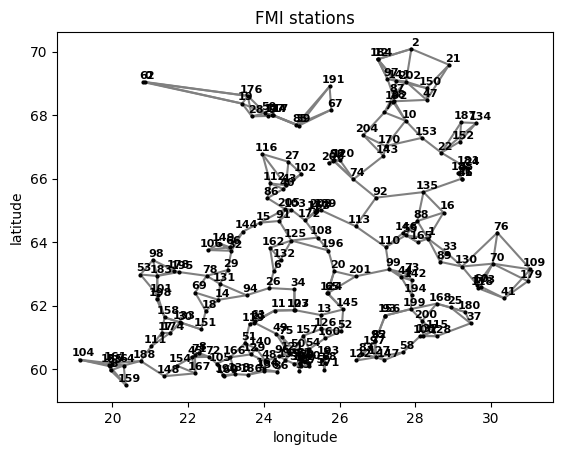

In [44]:
# Create a networkX graph.
G_FMI = nx.Graph()

# Add a one node per station.
G_FMI.add_nodes_from(range(0, num_stations))

# Add node attributes: station name, feature, and label.
yglobal = np.array([])

for i, station in enumerate(data.name.unique()):
    # Extract data of a certain station.
    station_data = data[data.name==station]
    
    # Extract features and labels.
    X, y = ExtractFeaureMatrixLabvelVector(station_data)
    
    localsamplesize = len(y)
    G_FMI.nodes[i]['samplesize'] = localsamplesize # The number of measurements of the i-th weather station
    G_FMI.nodes[i]['X'] = X # The feature matrix for local dataset at node i
    G_FMI.nodes[i]['name'] = station # The name of the i-th weather station
    G_FMI.nodes[i]['coord'] = (station_data.Latitude.unique()[0], station_data.Longitude.unique()[0]) # The coordinates of the i-th weather station 
    G_FMI.nodes[i]['y'] = y  # The label vector for local dataset at node i
    yglobal = np.append(yglobal, y)

# Add edges between each station and its nearest neighbors.
# NOTE: the node degree might be different for different nodes.
numneighbors = 3
G_FMI = add_edges(G_FMI, numneighbors=numneighbors)

# Visualize the empirical graph.
plotFMI(G_FMI)

## 3. Model

### 3.1 Student task #1 - Training error and total variation

In [45]:
print(yglobal.shape)

(19768,)


(1449, 1449)
(1449, 1)
Training error: 6624.403451864921
Total variation: [8682952.30823629]


ValueError: x and y must be the same size

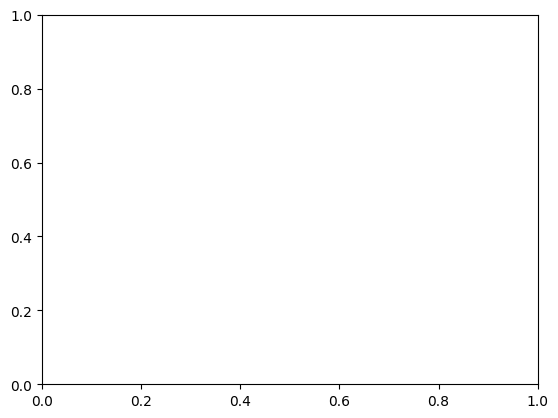

In [75]:
# Define the regularization parameter
gtvmin_alpha = 1

####################TODO####################
# TODO: 1. Generate the Laplacian matrix for the empirical graph.
#       2. Build matrix Q (Eq. (3.18)) and vector q (Eq. (3.19)) for the quadratic objective 
#          function in GTVMin (see Eq. (3.17)) in the Lecture Notes.
#       3. Use the zero-gradient condition (see Lecture Notes) to compute a solution for the GTVMin instance.

# raise NotImplementedError

###########################
# STUDENT SOLUTION STARTS #
###########################

# Initialize block matrices and vectors
block_Qs = []
block_qs = []

# Add the Laplacian term to Q
L_FMI = nx.laplacian_matrix(G_FMI).toarray()

# num_stations x num_features = 207 x 7 = 1449, which will be the main shape of Q and q

for i in range(num_stations):
    # Extract X and y for station i
    X_i = G_FMI.nodes[i]['X']
    y_i = G_FMI.nodes[i]['y']
    m_i = G_FMI.nodes[i]['samplesize']

    #print(X_i.shape)
    #print(y_i.shape)
    #print(m_i)

    # Compute Q^(i) and q^(i)
    # Q_I = (1/m_i) * X_i.T @ X_i + gtvmin_alpha * L_FMI kronecker I 
    Q_i = (1/m_i) * X_i.T @ X_i 
    q_i = (-2/m_i) * X_i.T @ y_i
    #print(Q_i.shape)
    #print(q_i.shape)
    
    # Append to the block lists
    block_Qs.append(Q_i)
    block_qs.append(q_i)

import scipy
# Assemble the block-diagonal matrix Q
Q = scipy.linalg.block_diag(*block_Qs)

#print(block_Qs[1].shape)
print(Q.shape)

Q += gtvmin_alpha * np.kron(L_FMI, np.eye(Q_i.shape[1]))

# Concatenate all q_i vectors to form q
q = np.concatenate(block_qs)

print(q.shape)

# Compute the inverse of Q
Q_inv = np.linalg.inv(Q)

# Compute hat_w
hat_w = (-1/2) * Q_inv @ q

###########################
# STUDENT SOLUTION ENDS   #
###########################

# L_FMI = 
# Q = 
# q = 
# hat_w =

# The training error options is either 32, 35, or 38 as reference

# Calculate and print the training error and the total variation.
print("Training error:", compute_train_err(G_FMI, hat_w))
print("Total variation:", compute_totalvariation(G_FMI, hat_w))

# Get the coordinates of each weather station
coords = nx.get_node_attributes(G_FMI, 'coord')
coords = np.array(list(coords.values()))

# Visualize the learnt model paramters in scatter plot using 
# the longitue value as horizontal axis.  
plt.scatter(coords[:,1], hat_w)
plt.xlabel("Longitude ot station")
plt.ylabel("Local model parameter w")
plt.show()

### 3.2 Student task #2 - The connectivity of the empirical graph

In [47]:
####################TODO####################
# TODO: Construct different variants G_FMI using the above function add_edges() with 
#       different choices for the parameter "nrneighbors" (1, 2, 3, and 4) and 
#       determine for each value if G_FMI is connected.

# raise NotImplementedError

def is_connected(G):
    return nx.is_connected(G)

neighborhood_sizes = [1, 2, 3, 4]
connectivity_results = {}

for nrneighbors in neighborhood_sizes:
    G_variant = G_FMI.copy()
    # Use the add_edges function to add edges to the graph based on the number of neighbors
    G_variant = add_edges(G_variant, nrneighbors)
    # Check if the graph is connected
    connectivity_results[nrneighbors] = is_connected(G_variant)

for nrneighbors, connected in connectivity_results.items():
    print(f"Graph with {nrneighbors} neighbors is", "connected" if connected else "not connected")

Graph with 1 neighbors is not connected
Graph with 2 neighbors is not connected
Graph with 3 neighbors is not connected
Graph with 4 neighbors is connected


### 3.3 Student task #3 - GTVMin alpha impact

In [48]:
####################TODO####################
# TODO: Construct G_FMI for nrneighbors=5 and learn local model parameters using 
#       GTVMIN with different choices for alpha (1, 10, 100, and 1000).
#       For each choice of alpha, determine the average local loss (training error) 
#       and the total variation of the learnt local model parameters.

# raise NotImplementedError

# Define the regularization parameter values to test
alpha_values = [1, 10, 100, 1000]
training_errors = {}
total_variations = {}

# Assuming that yglobal is already the average temperature for each station

# Construct G_FMI for nrneighbors=5
G_FMI = add_edges(G_FMI, numneighbors=5)

# Learn local model parameters for each value of alpha and compute training error and total variation
for alpha in alpha_values:
    # Build matrix Q and vector q for the quadratic objective function
    L_FMI = nx.laplacian_matrix(G_FMI).toarray()
    Q = 2 * (np.dot(L_FMI.T, L_FMI) + alpha * np.eye(L_FMI.shape[0]))
    q = -2 * alpha * average_temps

    # Solve the system using the normal equations
    # To solve Qw = q, we can use np.linalg.solve instead of calculating the inverse for better numerical stability
    hat_w = np.linalg.solve(Q, q)
    # Calculate and store the training error and total variation for the current alpha
    training_errors[alpha] = compute_train_err(G_FMI, w_hat)
    total_variations[alpha] = compute_totalvariation(G_FMI, w_hat)

# Display the results
for alpha in alpha_values:
    print(f"Alpha: {alpha}")
    print(f"Training Error: {training_errors[alpha]}")
    print(f"Total Variation: {total_variations[alpha]}")
    print()


Alpha: 1
Training Error: 595.3071526887696
Total Variation: 676.2163800456843

Alpha: 10
Training Error: 595.3071526887696
Total Variation: 676.2163800456843

Alpha: 100
Training Error: 595.3071526887696
Total Variation: 676.2163800456843

Alpha: 1000
Training Error: 595.3071526887696
Total Variation: 676.2163800456843

